In [662]:
import pandas as pd
import numpy as np
from arch import arch_model
import yfinance as yf
import matplotlib.pyplot as plt

In [664]:

# Define the start and end dates
start_date = "2013-07-30"
end_date = "2024-11-30"

# 1. Download Eurostoxx50 and Gold Data
eurostoxx50_data = yf.download("^STOXX50E", start=start_date, end=end_date)
# Drop unneded columns


gold_data = yf.download("GC=F",  start=start_date, end=end_date) # Gold Futures-> sind leicht off zu den Spotpreis
# Drop unneded columns

# Define the start and end dates
start_date = "2013-07-30"
end_date = "2024-11-30"

# 1. Download Eurostoxx50 and Gold Data
eurostoxx50_data = yf.download("^STOXX50E", start=start_date, end=end_date)

# Drop unneeded columns from Eurostoxx50
eurostoxx50_data = eurostoxx50_data[['Open','Close','Volume']]  # Retain only the 'Close' column

gold_data = yf.download("GC=F", start=start_date, end=end_date)  # Gold Futures
# Drop unneeded columns from Gold Data
gold_data = gold_data[['Open','Close']]  # Retain only the 'Close' column



[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


In [666]:

# Display the first few rows of the cleaned data
print("Eurostoxx50 Data:")
print(eurostoxx50_data.head())


print("\nGold Data:")
print(gold_data.head())

Eurostoxx50 Data:
                   Open        Close    Volume
Date                                          
2013-07-30  2750.270020  2759.209961  44278700
2013-07-31  2749.669922  2768.149902  43668400
2013-08-02  2816.139893  2811.000000  56128500
2013-08-05  2815.260010  2809.080078  33450100
2013-08-06  2809.179932  2790.780029  53265000

Gold Data:
                   Open        Close
Date                                
2013-07-30  1327.199951  1324.000000
2013-07-31  1325.500000  1312.400024
2013-08-01  1323.000000  1311.000000
2013-08-02  1306.699951  1310.599976
2013-08-05  1311.199951  1302.599976


In [668]:
# Load VSTOXX Data (CSV)
vstoxx_data = pd.read_csv("VSTOXX_data.csv", parse_dates=['Date'])
vstoxx_data.set_index('Date', inplace=True)

# Drop the 'Vol.' column
vstoxx_data.drop(columns=['Vol.','Open','High','Low','Change %'], inplace=True)

# Verify the remaining columns
print(vstoxx_data.head())



            Close
Date             
2024-11-29  16.96
2024-11-28  17.60
2024-11-27  18.30
2024-11-26  17.73
2024-11-25  17.21


In [670]:
# Ensure the index is sorted before slicing
vstoxx_data.sort_index(inplace=True)

# Slice the data to start from 2013
vstoxx_data = vstoxx_data.loc[start_date:]

In [672]:
# Verify the remaining columns
print(vstoxx_data.head())


            Close
Date             
2013-07-30  18.84
2013-07-31  19.06
2013-08-01  23.31
2013-08-02  16.82
2013-08-05  17.33


In [674]:
# 3. Load Basel Temperature Data (CSV)
basel_temp_data = pd.read_csv("Temp_Data_Basel.csv")
basel_temp_data['Date'] = pd.to_datetime(basel_temp_data['timestamp'], format='%Y%m%dT%H%M', errors='coerce')
basel_temp_data.set_index('Date', inplace=True)
basel_temp_data = basel_temp_data[['Basel Temperature Mean']].loc[start_date:]  # Filter to start from 2013



In [676]:
print(basel_temp_data.head())

            Basel Temperature Mean
Date                              
2013-07-30               20.143862
2013-07-31               22.646780
2013-08-01               25.205530
2013-08-02               28.381363
2013-08-03               25.519693


In [678]:
# 4. Load EURIBOR Data (Monthly CSV)
euribor_data = pd.read_csv("EURIBOR_3Month.csv", parse_dates=['DATE'])
euribor_data.set_index('DATE', inplace=True)
euribor_data = euribor_data[['Average close']].resample('D').ffill().bfill().loc[start_date:]  # Resample and filter



In [680]:
print(euribor_data.head())

            Average close
DATE                     
2013-07-30         0.2103
2013-07-31         0.2214
2013-08-01         0.2214
2013-08-02         0.2214
2013-08-03         0.2214


In [682]:
# 5. Load Oil Price Data (CSV)
oil_data = pd.read_csv("Cleaned_Oil_data.csv", parse_dates=['DATE'])
oil_data.set_index('DATE', inplace=True)
print(oil_data.head())

            Europe Brent Spot Price FOB (Dollars per Barrel)
DATE                                                        
1987-05-20                                             18.63
1987-05-21                                             18.45
1987-05-22                                             18.55
1987-05-25                                             18.60
1987-05-26                                             18.63


In [684]:
# 6. Load Euro/Dollar Price (CSV)
dollar_data = pd.read_csv("Euro_Dollar_Chart.csv", parse_dates=['DATE'])
dollar_data.set_index('DATE', inplace=True)
dollar_data.drop(columns=['TIME PERIOD'], inplace=True)
print(dollar_data.head())

            US dollar/Euro (EXR.D.USD.EUR.SP00.A)
DATE                                             
1999-01-04                                 1.1789
1999-01-05                                 1.1790
1999-01-06                                 1.1743
1999-01-07                                 1.1632
1999-01-08                                 1.1659


In [686]:
# Add suffixes only if not already present
def add_suffix_safe(df, suffix):
    return df.rename(columns=lambda x: f"{x}{suffix}" if not x.endswith(suffix) else x)

# Apply the suffix-safe function
eurostoxx50_data = add_suffix_safe(eurostoxx50_data, '_Eurostoxx50')
vstoxx_data = add_suffix_safe(vstoxx_data, '_VSTOXX')
basel_temp_data = add_suffix_safe(basel_temp_data, '_BaselTemp')
euribor_data = add_suffix_safe(euribor_data, '_EURIBOR')
gold_data = add_suffix_safe(gold_data, '_Gold')
oil_data = add_suffix_safe(oil_data, '_Oil')
dollar_data = add_suffix_safe(dollar_data, '_Dollar')

# Merge datasets
dataset = eurostoxx50_data.copy()
dataset = dataset.join(vstoxx_data, how='outer')
dataset = dataset.join(basel_temp_data, how='outer')
dataset = dataset.join(euribor_data, how='outer')
dataset = dataset.join(gold_data, how='outer')
dataset = dataset.join(oil_data, how='outer')
dataset = dataset.join(dollar_data, how='outer')

# Handle missing values
dataset = dataset.ffill().dropna()

# Save to a new CSV file
dataset.to_csv("Unified_Dataset_2013_Onward.csv")

# Display the first few rows
print(dataset.head())

            Open_Eurostoxx50  Close_Eurostoxx50  Volume_Eurostoxx50  \
2013-07-30       2750.270020        2759.209961          44278700.0   
2013-07-31       2749.669922        2768.149902          43668400.0   
2013-08-01       2749.669922        2768.149902          43668400.0   
2013-08-02       2816.139893        2811.000000          56128500.0   
2013-08-03       2816.139893        2811.000000          56128500.0   

            Close_VSTOXX  Basel Temperature Mean_BaselTemp  \
2013-07-30         18.84                         20.143862   
2013-07-31         19.06                         22.646780   
2013-08-01         23.31                         25.205530   
2013-08-02         16.82                         28.381363   
2013-08-03         16.82                         25.519693   

            Average close_EURIBOR    Open_Gold   Close_Gold  \
2013-07-30                 0.2103  1327.199951  1324.000000   
2013-07-31                 0.2214  1325.500000  1312.400024   
2013-08-01 

In [688]:
# Function to check dataset validity
def check_dataset(dataset, dataset_name):
    print(f"\nChecking {dataset_name}...")
    if dataset.empty:
        print(f"{dataset_name} is empty.")
        return
    print(f"{dataset_name} has {dataset.shape[0]} rows and {dataset.shape[1]} columns.")

    # Check for missing values
    missing_values = dataset.isnull().sum().sum()
    if missing_values > 0:
        print(f"{dataset_name} has {missing_values} missing values.")
    else:
        print(f"{dataset_name} has no missing values.")

    # Check for all-zero rows or columns
    all_zero_rows = (dataset == 0).all(axis=1).sum()
    all_zero_columns = (dataset == 0).all(axis=0).sum()
    if all_zero_rows > 0:
        print(f"{dataset_name} has {all_zero_rows} rows with all zeros.")
    if all_zero_columns > 0:
        print(f"{dataset_name} has {all_zero_columns} columns with all zeros.")

    # Check for constant columns (no variability)
    constant_columns = dataset.nunique(dropna=True)[dataset.nunique(dropna=True) == 1].index.tolist()
    if constant_columns:
        print(f"{dataset_name} has {len(constant_columns)} constant columns: {constant_columns}")
    else:
        print(f"{dataset_name} has no constant columns.")



In [690]:
# Check each dataset
check_dataset(eurostoxx50_data, "Eurostoxx50")
check_dataset(vstoxx_data, "VSTOXX")
check_dataset(basel_temp_data, "Basel Temperature")
check_dataset(dollar_data, "Dollar Price")
check_dataset(oil_data, "Oil Price")
check_dataset(gold_data, "Gold Price")



Checking Eurostoxx50...
Eurostoxx50 has 2848 rows and 3 columns.
Eurostoxx50 has no missing values.
Eurostoxx50 has no constant columns.

Checking VSTOXX...
VSTOXX has 2896 rows and 1 columns.
VSTOXX has no missing values.
VSTOXX has no constant columns.

Checking Basel Temperature...
Basel Temperature has 4148 rows and 1 columns.
Basel Temperature has 2 missing values.
Basel Temperature has no constant columns.

Checking Dollar Price...
Dollar Price has 6705 rows and 1 columns.
Dollar Price has 62 missing values.
Dollar Price has no constant columns.

Checking Oil Price...
Oil Price has 9528 rows and 1 columns.
Oil Price has 1 missing values.
Oil Price has no constant columns.

Checking Gold Price...
Gold Price has 2853 rows and 2 columns.
Gold Price has no missing values.
Gold Price has no constant columns.


In [692]:
print(dataset.head())

            Open_Eurostoxx50  Close_Eurostoxx50  Volume_Eurostoxx50  \
2013-07-30       2750.270020        2759.209961          44278700.0   
2013-07-31       2749.669922        2768.149902          43668400.0   
2013-08-01       2749.669922        2768.149902          43668400.0   
2013-08-02       2816.139893        2811.000000          56128500.0   
2013-08-03       2816.139893        2811.000000          56128500.0   

            Close_VSTOXX  Basel Temperature Mean_BaselTemp  \
2013-07-30         18.84                         20.143862   
2013-07-31         19.06                         22.646780   
2013-08-01         23.31                         25.205530   
2013-08-02         16.82                         28.381363   
2013-08-03         16.82                         25.519693   

            Average close_EURIBOR    Open_Gold   Close_Gold  \
2013-07-30                 0.2103  1327.199951  1324.000000   
2013-07-31                 0.2214  1325.500000  1312.400024   
2013-08-01 

In [694]:
# Function to calculate indicators
def calculate_indicators(data, column_name, prefix):
    """
    Calculates Moving Average, RSI, and MACD indicators and returns them in a new DataFrame.
    
    Parameters:
    - data: DataFrame containing the price data.
    - column_name: The column name for the price data (e.g., 'Close').
    - prefix: Prefix to use for the indicator columns (e.g., 'Eurostoxx50', 'VSTOXX').
    
    Returns:
    - DataFrame with calculated indicators.
    """
    indicators = pd.DataFrame(index=data.index)

    # Moving Average 50
    indicators[f'{prefix}_MA_50'] = data[column_name].rolling(window=50, min_periods=50).mean()

    # RSI Calculation
    delta = data[column_name].diff()
    gain = delta.where(delta > 0, 0).rolling(window=14, min_periods=14).mean()
    loss = -delta.where(delta < 0, 0).rolling(window=14, min_periods=14).mean()
    rs = gain / loss
    indicators[f'{prefix}_RSI'] = 100 - (100 / (1 + rs))

    # MACD Calculation
    ema_12 = data[column_name].ewm(span=12, adjust=False).mean()
    ema_26 = data[column_name].ewm(span=26, adjust=False).mean()
    indicators[f'{prefix}_MACD'] = ema_12 - ema_26
    indicators[f'{prefix}_MACD_Signal'] = indicators[f'{prefix}_MACD'].ewm(span=9, adjust=False).mean()

    return indicators

In [724]:
print(vstoxx_data.columns)
print(vstoxx_data.head())

Index(['Close_VSTOXX', 'Returns', 'VSTOXX_Log_Returns',
       'VSTOXX_GARCH_Volatility'],
      dtype='object')
            Close_VSTOXX   Returns  VSTOXX_Log_Returns  \
Date                                                     
2013-08-01         23.31  0.201291            0.201291   
2013-08-02         16.82 -0.326314           -0.326314   
2013-08-05         17.33  0.029870            0.029870   
2013-08-06         17.92  0.033478            0.033478   
2013-08-07         18.27  0.019343            0.019343   

            VSTOXX_GARCH_Volatility  
Date                                 
2013-08-01                10.039562  
2013-08-02                11.763076  
2013-08-05                16.253979  
2013-08-06                13.295937  
2013-08-07                11.083840  


In [718]:
print(eurostoxx50_data.columns)
print(eurostoxx50_data.head())

Index(['Open_Eurostoxx50', 'Close_Eurostoxx50', 'Volume_Eurostoxx50',
       'Returns'],
      dtype='object')
            Open_Eurostoxx50  Close_Eurostoxx50  Volume_Eurostoxx50   Returns
Date                                                                         
2013-07-31       2749.669922        2768.149902            43668400  0.003235
2013-08-02       2816.139893        2811.000000            56128500  0.015361
2013-08-05       2815.260010        2809.080078            33450100 -0.000683
2013-08-06       2809.179932        2790.780029            53265000 -0.006536
2013-08-07       2784.810059        2794.439941            51430500  0.001311


In [700]:
# Calculate indicators for Eurostoxx50
eurostoxx50_indicators = calculate_indicators(eurostoxx50_data, 'Close_Eurostoxx50', "Eurostoxx50")

# Calculate indicators for VSTOXX
vstoxx_indicators = calculate_indicators(vstoxx_data, 'Close_VSTOXX', 'VSTOXX')



In [708]:
print(eurostoxx50_indicators.tail())

            Eurostoxx50_MA_50  Eurostoxx50_RSI  Eurostoxx50_MACD  \
Date                                                               
2024-11-25        4896.156172        44.151345        -37.168272   
2024-11-26        4894.180381        46.613765        -36.818998   
2024-11-27        4892.137383        39.160661        -38.426414   
2024-11-28        4888.442783        45.793854        -37.213690   
2024-11-29        4887.099980        45.217135        -32.189889   

            Eurostoxx50_MACD_Signal  
Date                                 
2024-11-25               -37.587446  
2024-11-26               -37.433756  
2024-11-27               -37.632288  
2024-11-28               -37.548568  
2024-11-29               -36.476832  


In [710]:
print(vstoxx_indicators.tail())

            VSTOXX_MA_50  VSTOXX_RSI  VSTOXX_MACD  VSTOXX_MACD_Signal
Date                                                                 
2024-11-25       18.4188   37.956204    -0.163708           -0.127987
2024-11-26       18.4418   46.245059    -0.192871           -0.140964
2024-11-27       18.4666   58.724832    -0.168051           -0.146381
2024-11-28       18.5102   54.270833    -0.202531           -0.157611
2024-11-29       18.5256   50.830890    -0.278291           -0.181747


In [720]:
def calculate_garch_volatility(data, column_name, prefix):
    """
    Calculates GARCH(1,1) volatility forecasts and adds them as a new column to the dataset.
    
    Parameters:
    - data: DataFrame containing the price data.
    - column_name: The column name for the price data (e.g., 'Close').
    - prefix: Prefix to use for the volatility column (e.g., 'Eurostoxx50', 'VSTOXX').
    """
    # Check if column exists and contains valid data
    if column_name not in data.columns or data[column_name].isnull().all():
        print(f"Column {column_name} missing or empty in dataset.")
        return data

    # Calculate log returns
    data[f'{prefix}_Log_Returns'] = np.log(data[column_name] / data[column_name].shift(1))
    data.dropna(subset=[f'{prefix}_Log_Returns'], inplace=True)  # Remove NaN values introduced by returns calculation

    # Ensure there are enough data points
    if len(data[f'{prefix}_Log_Returns']) < 30:
        print(f"Not enough data for GARCH calculation in {prefix}.")
        data[f'{prefix}_GARCH_Volatility'] = np.nan
        return data

    # Rescale log returns for GARCH
    scaled_returns = data[f'{prefix}_Log_Returns'] * 100

    # Fit GARCH(1,1) model
    garch_model = arch_model(scaled_returns, vol='Garch', p=1, q=1, rescale=False)
    garch_result = garch_model.fit(disp="off")

    # Get volatility forecast
    data[f'{prefix}_GARCH_Volatility'] = garch_result.conditional_volatility
    return data



In [722]:
# Calculate log returns for Eurostoxx50
eurostoxx50_data['Eurostoxx50_Log_Returns'] = np.log(
    eurostoxx50_data['Close_Eurostoxx50'] / eurostoxx50_data['Close_Eurostoxx50'].shift(1)
)

# Calculate log returns for VSTOXX
vstoxx_data['VSTOXX_Log_Returns'] = np.log(
    vstoxx_data['Close_VSTOXX'] / vstoxx_data['Close_VSTOXX'].shift(1)
)

# Remove NaN values introduced by log return calculation
eurostoxx50_data.dropna(subset=['Eurostoxx50_Log_Returns'], inplace=True)
vstoxx_data.dropna(subset=['VSTOXX_Log_Returns'], inplace=True)

# Apply GARCH model to Eurostoxx50
print("Eurostoxx50 GARCH Model:")
model_eurostoxx50 = arch_model(
    eurostoxx50_data['Eurostoxx50_Log_Returns'] * 100, vol='Garch', p=1, q=1, rescale=False
)
result_eurostoxx50 = model_eurostoxx50.fit(disp="off")
eurostoxx50_data['Eurostoxx50_GARCH_Volatility'] = result_eurostoxx50.conditional_volatility
print(result_eurostoxx50.summary())

# Apply GARCH model to VSTOXX
print("\nVSTOXX GARCH Model:")
model_vstoxx = arch_model(
    vstoxx_data['VSTOXX_Log_Returns'] * 100, vol='Garch', p=1, q=1, rescale=False
)
result_vstoxx = model_vstoxx.fit(disp="off")
vstoxx_data['VSTOXX_GARCH_Volatility'] = result_vstoxx.conditional_volatility
print(result_vstoxx.summary())

Eurostoxx50 GARCH Model:
                        Constant Mean - GARCH Model Results                        
Dep. Variable:     Eurostoxx50_Log_Returns   R-squared:                       0.000
Mean Model:                  Constant Mean   Adj. R-squared:                  0.000
Vol Model:                           GARCH   Log-Likelihood:               -4167.21
Distribution:                       Normal   AIC:                           8342.42
Method:                 Maximum Likelihood   BIC:                           8366.24
                                             No. Observations:                 2846
Date:                     Sun, Dec 08 2024   Df Residuals:                     2845
Time:                             12:43:49   Df Model:                            1
                                 Mean Model                                 
                 coef    std err          t      P>|t|      95.0% Conf. Int.
-----------------------------------------------------------------

In [741]:
# Reload the unified dataset to ensure a clean start
unified_dataset = pd.read_csv("Unified_Dataset_2013_Onward.csv", index_col=0, parse_dates=True)

# Ensure all datasets are aligned with Eurostoxx50 trading days
# Align Eurostoxx50 returns
eurostoxx50_data['Returns'] = eurostoxx50_data['Returns'].reindex(unified_dataset.index)

# Align Eurostoxx50 GARCH volatility
eurostoxx50_data['Eurostoxx50_GARCH_Volatility'] = eurostoxx50_data['Eurostoxx50_GARCH_Volatility'].reindex(unified_dataset.index)

# Align VSTOXX GARCH volatility
vstoxx_data['VSTOXX_GARCH_Volatility'] = vstoxx_data['VSTOXX_GARCH_Volatility'].reindex(unified_dataset.index)

# Combine the aligned datasets
unified_dataset['Eurostoxx50_Returns'] = eurostoxx50_data['Returns']
unified_dataset['Eurostoxx50_GARCH_Volatility'] = eurostoxx50_data['Eurostoxx50_GARCH_Volatility']
unified_dataset['VSTOXX_GARCH_Volatility'] = vstoxx_data['VSTOXX_GARCH_Volatility']

# Handle missing values (forward-fill or drop)
unified_dataset = unified_dataset.ffill().dropna()

# Save the updated dataset
unified_dataset.to_csv("Unified_Dataset_2013_Onward_Updated.csv")

# Display a summary to confirm
print(unified_dataset.info())
print(unified_dataset.head())

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 4145 entries, 2013-08-02 to 2024-12-06
Data columns (total 13 columns):
 #   Column                                                Non-Null Count  Dtype  
---  ------                                                --------------  -----  
 0   Open_Eurostoxx50                                      4145 non-null   float64
 1   Close_Eurostoxx50                                     4145 non-null   float64
 2   Volume_Eurostoxx50                                    4145 non-null   float64
 3   Close_VSTOXX                                          4145 non-null   float64
 4   Basel Temperature Mean_BaselTemp                      4145 non-null   float64
 5   Average close_EURIBOR                                 4145 non-null   float64
 6   Open_Gold                                             4145 non-null   float64
 7   Close_Gold                                            4145 non-null   float64
 8   Europe Brent Spot Price FOB (Dollars per

In [744]:
# Ensure the dataset has daily returns
if 'Eurostoxx50_Returns' not in unified_dataset.columns:
    raise ValueError("Daily returns ('Eurostoxx50_Returns') are not present in the dataset.")

# Calculate cumulative returns for the last 5 days
unified_dataset['Eurostoxx50_Cumulative_5D_Returns'] = unified_dataset['Eurostoxx50_Returns'].rolling(window=5, min_periods=5).sum()

# Handle missing values (optional: drop or forward-fill)
unified_dataset = unified_dataset.dropna(subset=['Eurostoxx50_Cumulative_5D_Returns'])

# Save the updated dataset
unified_dataset.to_csv("Unified_Dataset_2013_Onward_With_Cumulative_Returns.csv")

# Display a summary to confirm
print(unified_dataset.info())
print(unified_dataset[['Eurostoxx50_Returns', 'Eurostoxx50_Cumulative_5D_Returns']].head(10))


<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 4141 entries, 2013-08-06 to 2024-12-06
Data columns (total 14 columns):
 #   Column                                                Non-Null Count  Dtype  
---  ------                                                --------------  -----  
 0   Open_Eurostoxx50                                      4141 non-null   float64
 1   Close_Eurostoxx50                                     4141 non-null   float64
 2   Volume_Eurostoxx50                                    4141 non-null   float64
 3   Close_VSTOXX                                          4141 non-null   float64
 4   Basel Temperature Mean_BaselTemp                      4141 non-null   float64
 5   Average close_EURIBOR                                 4141 non-null   float64
 6   Open_Gold                                             4141 non-null   float64
 7   Close_Gold                                            4141 non-null   float64
 8   Europe Brent Spot Price FOB (Dollars per

In [747]:
# Recalculate indicators for Eurostoxx50
eurostoxx50_indicators = calculate_indicators(eurostoxx50_data, 'Close_Eurostoxx50', 'Eurostoxx50')

# Recalculate indicators for VSTOXX
vstoxx_indicators = calculate_indicators(vstoxx_data, 'Close_VSTOXX', 'VSTOXX')

In [751]:
# Select relevant columns to add to the unified dataset
eurostoxx50_selected = eurostoxx50_indicators[
    ['Eurostoxx50_MA_50', 'Eurostoxx50_RSI', 'Eurostoxx50_MACD', 'Eurostoxx50_MACD_Signal']
]
vstoxx_selected = vstoxx_indicators[
    ['VSTOXX_MA_50', 'VSTOXX_RSI', 'VSTOXX_MACD', 'VSTOXX_MACD_Signal']
]

# Merge the indicators into the unified dataset
unified_dataset = unified_dataset.join(eurostoxx50_selected, how='left')
unified_dataset = unified_dataset.join(vstoxx_selected, how='left')

# Handle missing values (forward-fill and drop residual NaNs)
unified_dataset = unified_dataset.ffill().dropna()

# Save the updated dataset
unified_dataset.to_csv("Unified_Dataset_2013_Onward_With_Indicators.csv")

# Display a summary to confirm
print(unified_dataset.info())
print(unified_dataset.head())

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 4075 entries, 2013-10-11 to 2024-12-06
Data columns (total 22 columns):
 #   Column                                                Non-Null Count  Dtype  
---  ------                                                --------------  -----  
 0   Open_Eurostoxx50                                      4075 non-null   float64
 1   Close_Eurostoxx50                                     4075 non-null   float64
 2   Volume_Eurostoxx50                                    4075 non-null   float64
 3   Close_VSTOXX                                          4075 non-null   float64
 4   Basel Temperature Mean_BaselTemp                      4075 non-null   float64
 5   Average close_EURIBOR                                 4075 non-null   float64
 6   Open_Gold                                             4075 non-null   float64
 7   Close_Gold                                            4075 non-null   float64
 8   Europe Brent Spot Price FOB (Dollars per

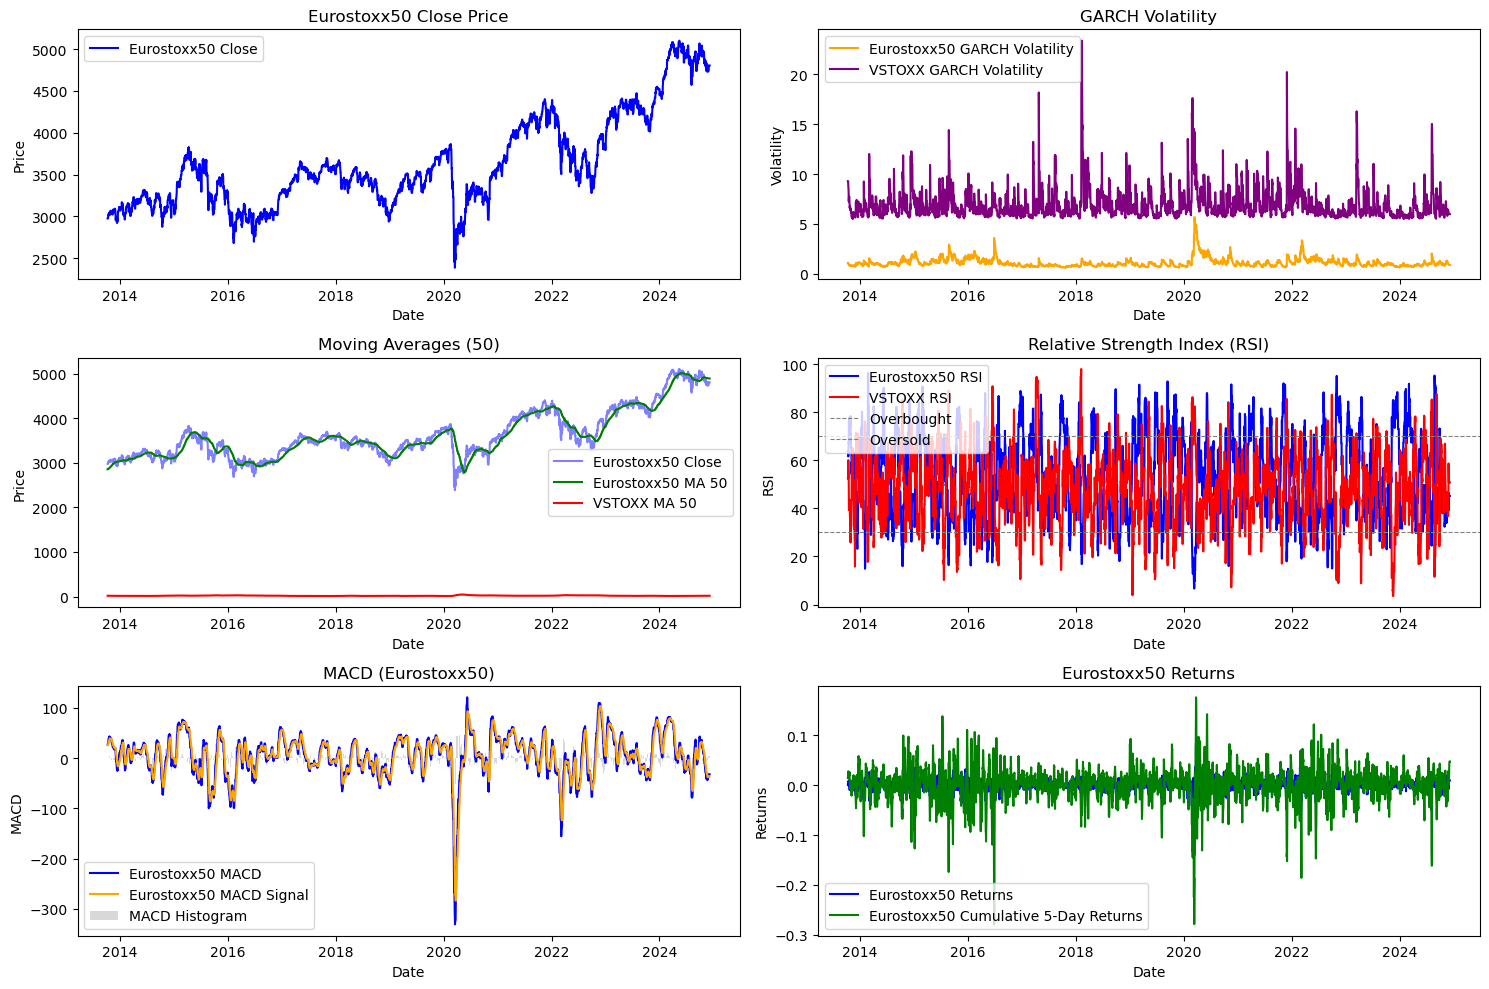

In [753]:


# Define a function for creating visualizations
def visualize_data(dataset):
    """
    Visualizes the dataset, including indicators, GARCH, and returns.
    
    Parameters:
    - dataset: The unified dataset with all indicators and GARCH values.
    """
    plt.figure(figsize=(15, 10))

    # 1. Eurostoxx50 Close Price
    plt.subplot(3, 2, 1)
    plt.plot(dataset.index, dataset['Close_Eurostoxx50'], label='Eurostoxx50 Close', color='blue')
    plt.title('Eurostoxx50 Close Price')
    plt.xlabel('Date')
    plt.ylabel('Price')
    plt.legend()

    # 2. GARCH Volatility
    plt.subplot(3, 2, 2)
    plt.plot(dataset.index, dataset['Eurostoxx50_GARCH_Volatility'], label='Eurostoxx50 GARCH Volatility', color='orange')
    plt.plot(dataset.index, dataset['VSTOXX_GARCH_Volatility'], label='VSTOXX GARCH Volatility', color='purple')
    plt.title('GARCH Volatility')
    plt.xlabel('Date')
    plt.ylabel('Volatility')
    plt.legend()

    # 3. Moving Averages
    plt.subplot(3, 2, 3)
    plt.plot(dataset.index, dataset['Close_Eurostoxx50'], label='Eurostoxx50 Close', color='blue', alpha=0.5)
    plt.plot(dataset.index, dataset['Eurostoxx50_MA_50'], label='Eurostoxx50 MA 50', color='green')
    plt.plot(dataset.index, dataset['VSTOXX_MA_50'], label='VSTOXX MA 50', color='red')
    plt.title('Moving Averages (50)')
    plt.xlabel('Date')
    plt.ylabel('Price')
    plt.legend()

    # 4. RSI
    plt.subplot(3, 2, 4)
    plt.plot(dataset.index, dataset['Eurostoxx50_RSI'], label='Eurostoxx50 RSI', color='blue')
    plt.plot(dataset.index, dataset['VSTOXX_RSI'], label='VSTOXX RSI', color='red')
    plt.axhline(70, color='gray', linestyle='--', linewidth=0.8, label='Overbought')
    plt.axhline(30, color='gray', linestyle='--', linewidth=0.8, label='Oversold')
    plt.title('Relative Strength Index (RSI)')
    plt.xlabel('Date')
    plt.ylabel('RSI')
    plt.legend()

    # 5. MACD
    plt.subplot(3, 2, 5)
    plt.plot(dataset.index, dataset['Eurostoxx50_MACD'], label='Eurostoxx50 MACD', color='blue')
    plt.plot(dataset.index, dataset['Eurostoxx50_MACD_Signal'], label='Eurostoxx50 MACD Signal', color='orange')
    plt.bar(dataset.index, dataset['Eurostoxx50_MACD'] - dataset['Eurostoxx50_MACD_Signal'], label='MACD Histogram', color='gray', alpha=0.3)
    plt.title('MACD (Eurostoxx50)')
    plt.xlabel('Date')
    plt.ylabel('MACD')
    plt.legend()

    # 6. Returns and Cumulative Returns
    plt.subplot(3, 2, 6)
    plt.plot(dataset.index, dataset['Eurostoxx50_Returns'], label='Eurostoxx50 Returns', color='blue')
    plt.plot(dataset.index, dataset['Eurostoxx50_Cumulative_5D_Returns'], label='Eurostoxx50 Cumulative 5-Day Returns', color='green')
    plt.title('Eurostoxx50 Returns')
    plt.xlabel('Date')
    plt.ylabel('Returns')
    plt.legend()

    plt.tight_layout()
    plt.show()

# Visualize the unified dataset
visualize_data(unified_dataset)


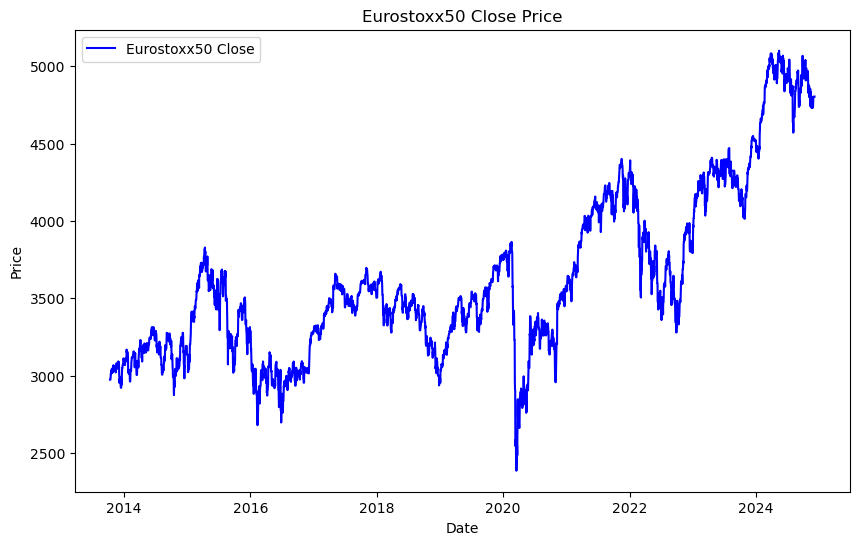

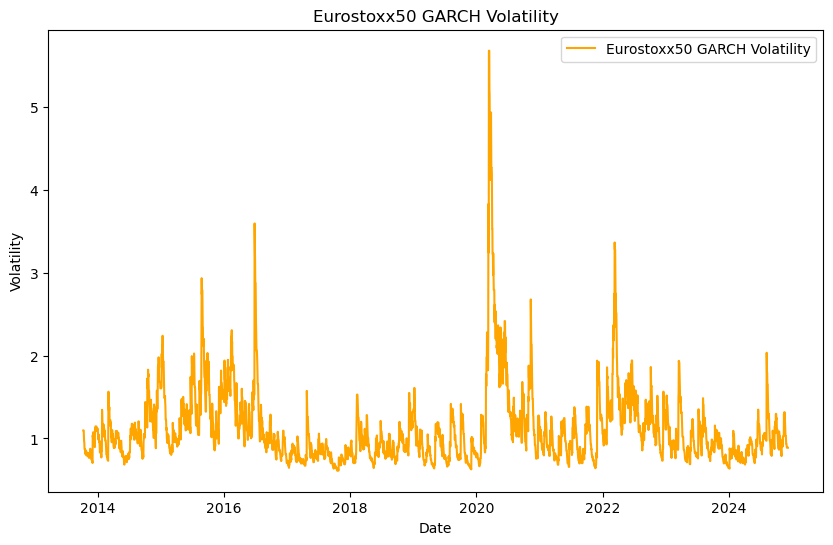

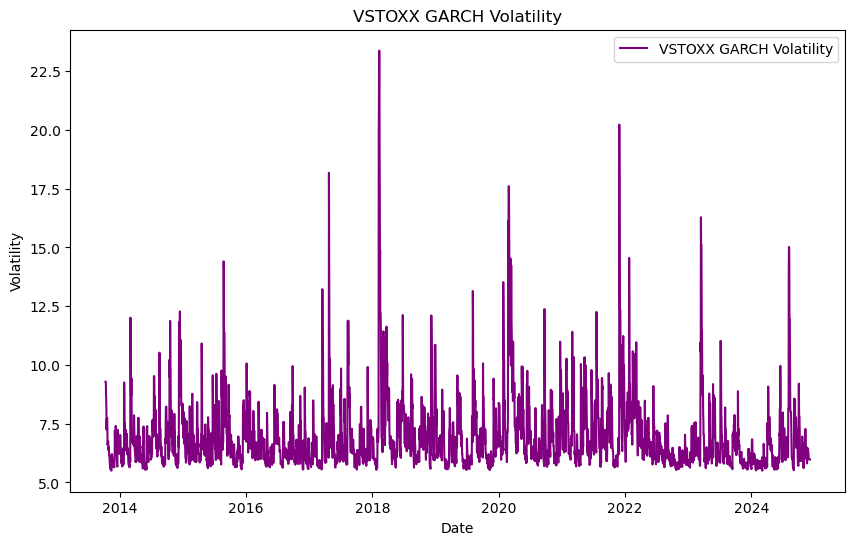

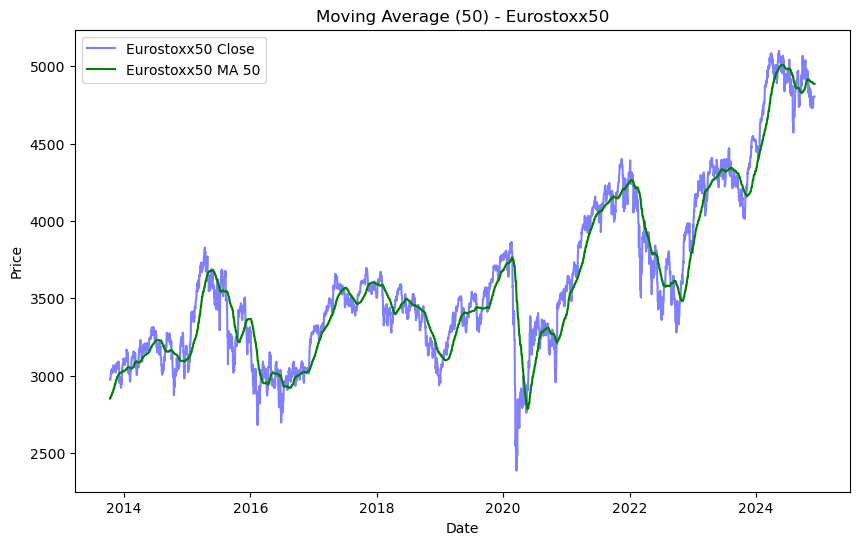

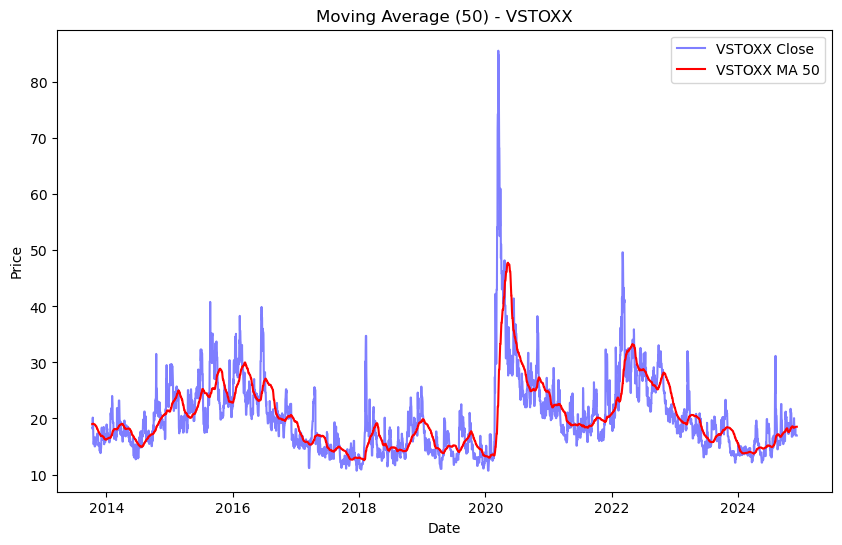

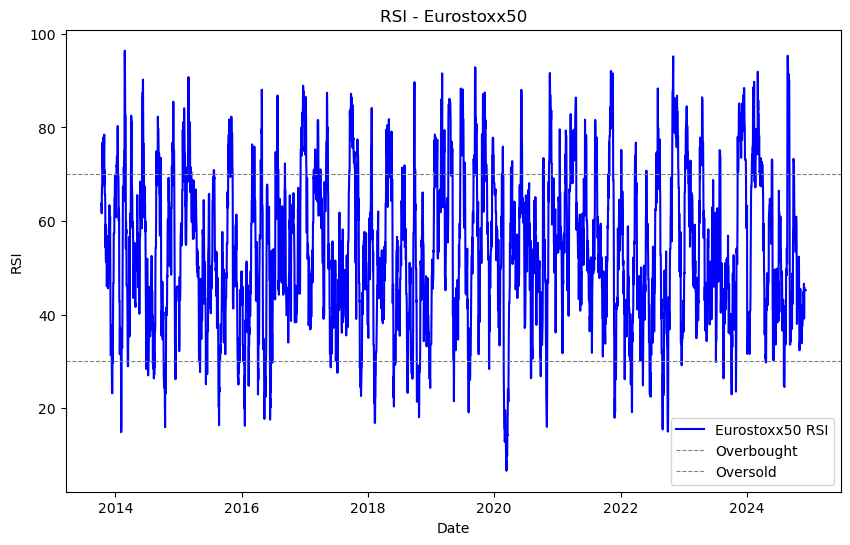

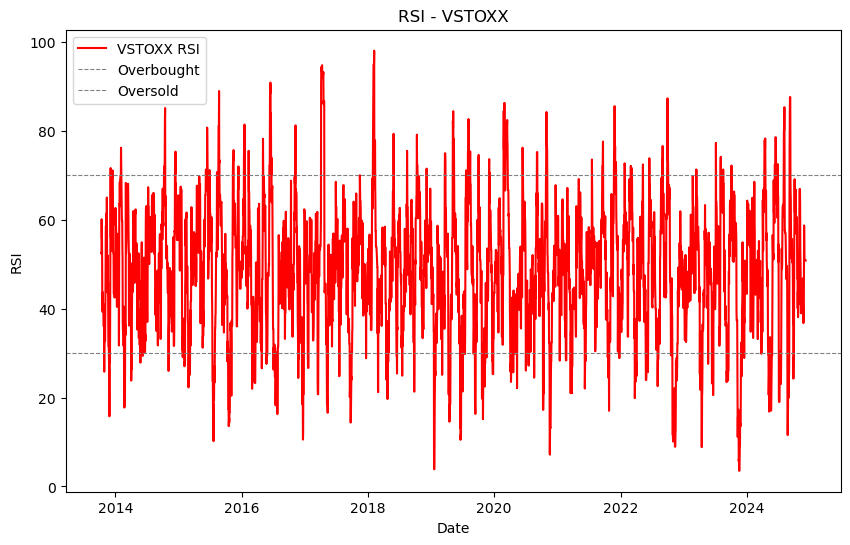

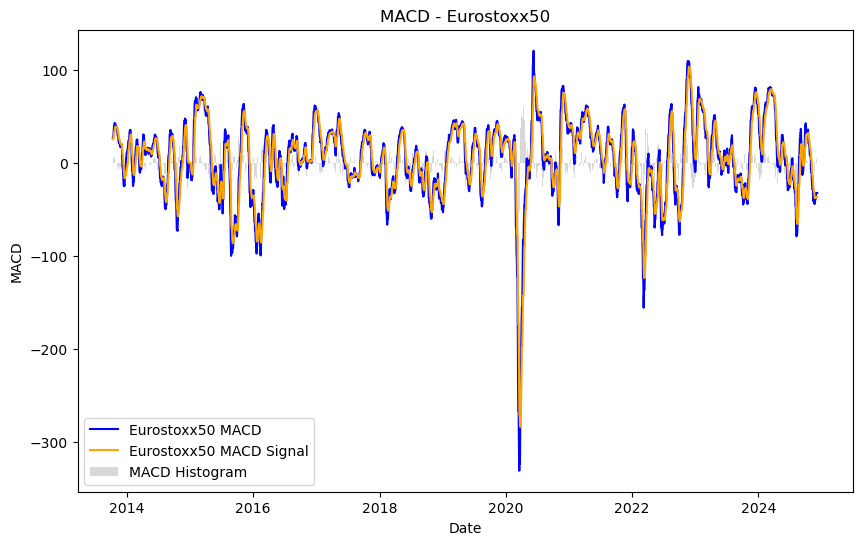

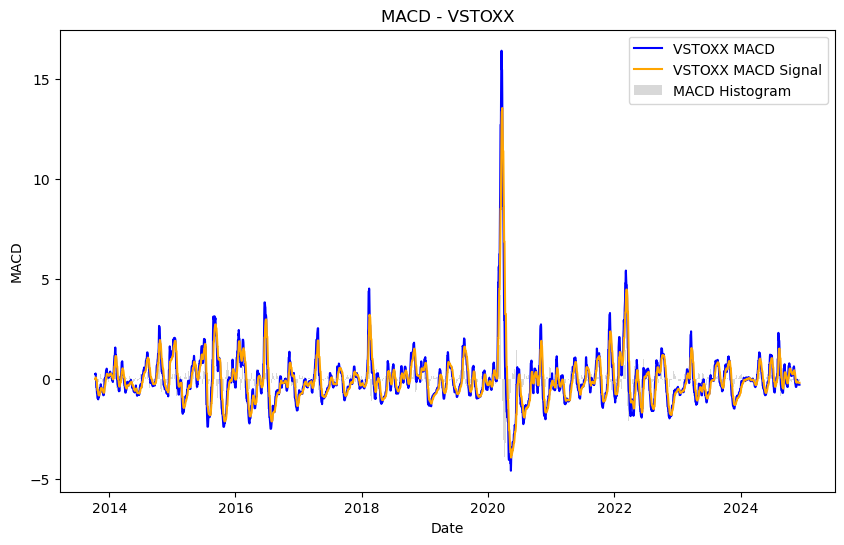

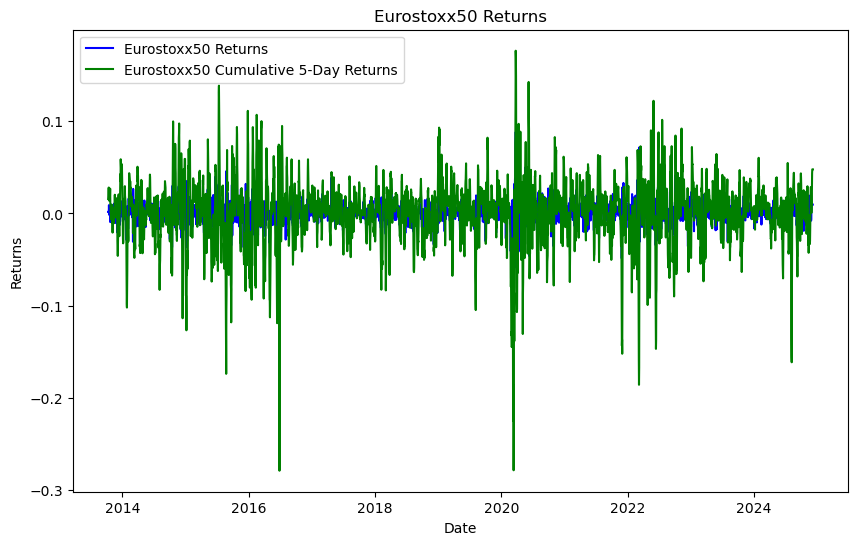

In [755]:
import matplotlib.pyplot as plt

# Define a function for creating individual visualizations
def visualize_data_individual(dataset):
    """
    Visualizes the dataset, including indicators, GARCH, and returns in individual plots.
    
    Parameters:
    - dataset: The unified dataset with all indicators and GARCH values.
    """
    # 1. Eurostoxx50 Close Price
    plt.figure(figsize=(10, 6))
    plt.plot(dataset.index, dataset['Close_Eurostoxx50'], label='Eurostoxx50 Close', color='blue')
    plt.title('Eurostoxx50 Close Price')
    plt.xlabel('Date')
    plt.ylabel('Price')
    plt.legend()
    plt.show()

    # 2. GARCH Volatility for Eurostoxx50
    plt.figure(figsize=(10, 6))
    plt.plot(dataset.index, dataset['Eurostoxx50_GARCH_Volatility'], label='Eurostoxx50 GARCH Volatility', color='orange')
    plt.title('Eurostoxx50 GARCH Volatility')
    plt.xlabel('Date')
    plt.ylabel('Volatility')
    plt.legend()
    plt.show()

    # 3. GARCH Volatility for VSTOXX
    plt.figure(figsize=(10, 6))
    plt.plot(dataset.index, dataset['VSTOXX_GARCH_Volatility'], label='VSTOXX GARCH Volatility', color='purple')
    plt.title('VSTOXX GARCH Volatility')
    plt.xlabel('Date')
    plt.ylabel('Volatility')
    plt.legend()
    plt.show()

    # 4. Moving Averages for Eurostoxx50
    plt.figure(figsize=(10, 6))
    plt.plot(dataset.index, dataset['Close_Eurostoxx50'], label='Eurostoxx50 Close', color='blue', alpha=0.5)
    plt.plot(dataset.index, dataset['Eurostoxx50_MA_50'], label='Eurostoxx50 MA 50', color='green')
    plt.title('Moving Average (50) - Eurostoxx50')
    plt.xlabel('Date')
    plt.ylabel('Price')
    plt.legend()
    plt.show()

    # 5. Moving Averages for VSTOXX
    plt.figure(figsize=(10, 6))
    plt.plot(dataset.index, dataset['Close_VSTOXX'], label='VSTOXX Close', color='blue', alpha=0.5)
    plt.plot(dataset.index, dataset['VSTOXX_MA_50'], label='VSTOXX MA 50', color='red')
    plt.title('Moving Average (50) - VSTOXX')
    plt.xlabel('Date')
    plt.ylabel('Price')
    plt.legend()
    plt.show()

    # 6. RSI for Eurostoxx50
    plt.figure(figsize=(10, 6))
    plt.plot(dataset.index, dataset['Eurostoxx50_RSI'], label='Eurostoxx50 RSI', color='blue')
    plt.axhline(70, color='gray', linestyle='--', linewidth=0.8, label='Overbought')
    plt.axhline(30, color='gray', linestyle='--', linewidth=0.8, label='Oversold')
    plt.title('RSI - Eurostoxx50')
    plt.xlabel('Date')
    plt.ylabel('RSI')
    plt.legend()
    plt.show()

    # 7. RSI for VSTOXX
    plt.figure(figsize=(10, 6))
    plt.plot(dataset.index, dataset['VSTOXX_RSI'], label='VSTOXX RSI', color='red')
    plt.axhline(70, color='gray', linestyle='--', linewidth=0.8, label='Overbought')
    plt.axhline(30, color='gray', linestyle='--', linewidth=0.8, label='Oversold')
    plt.title('RSI - VSTOXX')
    plt.xlabel('Date')
    plt.ylabel('RSI')
    plt.legend()
    plt.show()

    # 8. MACD for Eurostoxx50
    plt.figure(figsize=(10, 6))
    plt.plot(dataset.index, dataset['Eurostoxx50_MACD'], label='Eurostoxx50 MACD', color='blue')
    plt.plot(dataset.index, dataset['Eurostoxx50_MACD_Signal'], label='Eurostoxx50 MACD Signal', color='orange')
    plt.bar(dataset.index, dataset['Eurostoxx50_MACD'] - dataset['Eurostoxx50_MACD_Signal'], label='MACD Histogram', color='gray', alpha=0.3)
    plt.title('MACD - Eurostoxx50')
    plt.xlabel('Date')
    plt.ylabel('MACD')
    plt.legend()
    plt.show()

    # 9. MACD for VSTOXX
    plt.figure(figsize=(10, 6))
    plt.plot(dataset.index, dataset['VSTOXX_MACD'], label='VSTOXX MACD', color='blue')
    plt.plot(dataset.index, dataset['VSTOXX_MACD_Signal'], label='VSTOXX MACD Signal', color='orange')
    plt.bar(dataset.index, dataset['VSTOXX_MACD'] - dataset['VSTOXX_MACD_Signal'], label='MACD Histogram', color='gray', alpha=0.3)
    plt.title('MACD - VSTOXX')
    plt.xlabel('Date')
    plt.ylabel('MACD')
    plt.legend()
    plt.show()

    # 10. Returns and Cumulative Returns
    plt.figure(figsize=(10, 6))
    plt.plot(dataset.index, dataset['Eurostoxx50_Returns'], label='Eurostoxx50 Returns', color='blue')
    plt.plot(dataset.index, dataset['Eurostoxx50_Cumulative_5D_Returns'], label='Eurostoxx50 Cumulative 5-Day Returns', color='green')
    plt.title('Eurostoxx50 Returns')
    plt.xlabel('Date')
    plt.ylabel('Returns')
    plt.legend()
    plt.show()

# Call the function to visualize the data
visualize_data_individual(unified_dataset)


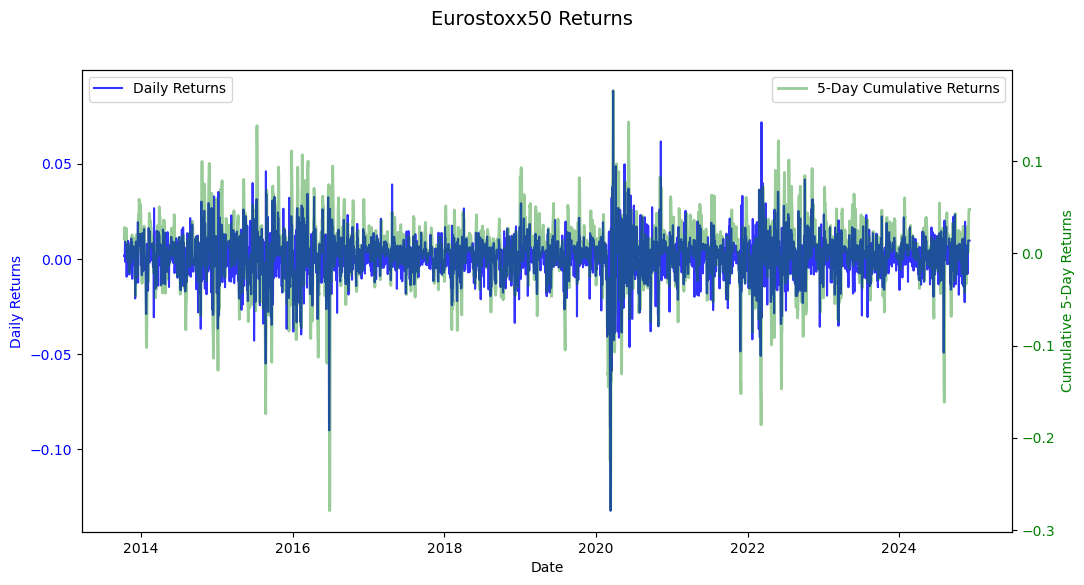

In [771]:
def plot_returns(dataset):
    """
    Plots Eurostoxx50 daily returns and cumulative 5-day returns with improved clarity.

    Parameters:
    - dataset: The unified dataset with returns and cumulative returns.
    """
    fig, ax1 = plt.subplots(figsize=(12, 6))

    # Plot daily returns with alpha for transparency
    ax1.plot(
        dataset.index, 
        dataset['Eurostoxx50_Returns'], 
        label='Daily Returns', 
        color='blue', 
        alpha=0.8
    )
    ax1.set_ylabel('Daily Returns', color='blue')
    ax1.tick_params(axis='y', labelcolor='blue')

    # Create a second y-axis for cumulative returns
    ax2 = ax1.twinx()
    ax2.plot(
        dataset.index, 
        dataset['Eurostoxx50_Cumulative_5D_Returns'], 
        label='5-Day Cumulative Returns', 
        color='green', 
        linewidth=2 ,
        alpha=0.4
    )
    ax2.set_ylabel('Cumulative 5-Day Returns', color='green')
    ax2.tick_params(axis='y', labelcolor='green')

    # Add titles and legend
    fig.suptitle('Eurostoxx50 Returns', fontsize=14)
    ax1.set_xlabel('Date')
    ax1.legend(loc='upper left')
    ax2.legend(loc='upper right')

    plt.show()

# Call the function to visualize returns
plot_returns(unified_dataset)